# Combined Analysis

Let's simply merge the CC'd corrected matrices from the seperate analyses and see how things cluster.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
ad_ctr = sc.read_10x_mtx(
    './sources/ctr',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)

ad_ctr.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

ad_sin = sc.read_10x_mtx(
    './sources/siN6amt1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)

ad_sin.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [3]:
ad_combi = ad_ctr.concatenate(ad_sin, join="outer", batch_key="SIN")
ad_combi
# Using 'outer' gave errors (due to NaN's?), 829 is still okay for clustering.

AnnData object with n_obs × n_vars = 8224 × 33694 
    obs: 'SIN'
    var: 'gene_ids-0', 'gene_ids-1'

In [38]:
# phew!
import gc
gc.collect()

0

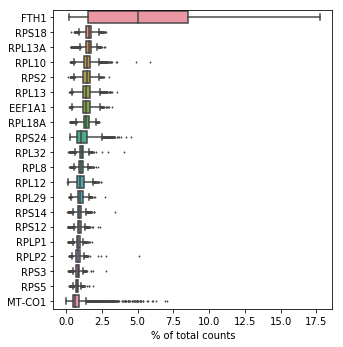

In [4]:
sc.pl.highest_expr_genes(ad_combi, n_top=20)

In [5]:
sc.pp.filter_cells(ad_combi, min_genes=200)
sc.pp.filter_genes(ad_combi, min_cells=3)

In [6]:
ad_combi

AnnData object with n_obs × n_vars = 8224 × 19962 
    obs: 'SIN', 'n_genes'
    var: 'gene_ids-0', 'gene_ids-1', 'n_cells'

In [7]:
def calcMito(obj):
    mito_genes = obj.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    obj.obs['percent_mito'] = np.sum(obj[:, mito_genes].X, axis=1).A1 / np.sum(obj.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    obj.obs['n_counts'] = obj.X.sum(axis=1).A1
    
calcMito(ad_combi)

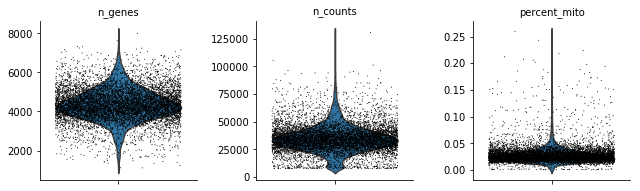

In [8]:
sc.pl.violin(ad_combi, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

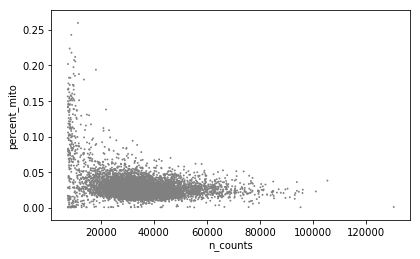

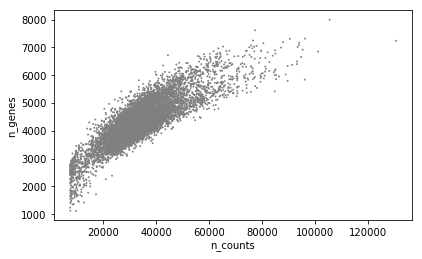

In [9]:
sc.pl.scatter(ad_combi, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_combi, x='n_counts', y='n_genes')

In [10]:
ad_combi = ad_combi[ad_combi.obs['n_genes'] < 7000, :]
ad_combi = ad_combi[ad_combi.obs['percent_mito'] < 0.05, :]

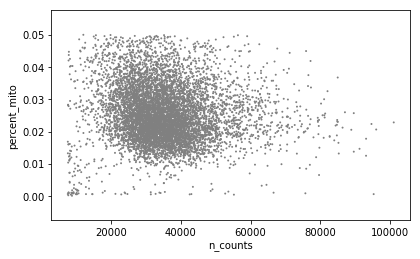

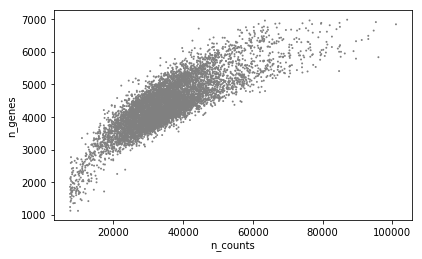

In [16]:
sc.pl.scatter(ad_combi, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_combi, x='n_counts', y='n_genes')

In [17]:
# We need to re-normalize our cells due to the different batches
sc.pp.normalize_per_cell(ad_combi, counts_per_cell_after=1e4)

In [18]:
sc.pp.log1p(ad_combi)

In [19]:
ad_combi.raw = ad_combi

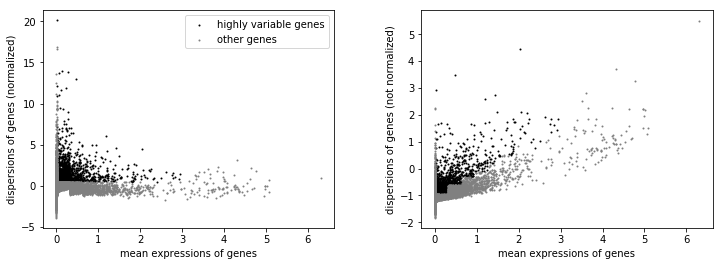

In [21]:
sc.pp.highly_variable_genes(ad_combi, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(ad_combi)

In [22]:
ad_combi = ad_combi[:, ad_combi.var['highly_variable']]
sc.pp.regress_out(ad_combi, ['n_counts', 'percent_mito'])

In [23]:
sc.pp.scale(ad_combi, max_value=10)

# Cell Cycle Check



In [25]:
# Load cell cycle genes from Tirosh genes
cell_cycle_genes = [x.strip() for x in open('./sources/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [26]:
cell_cycle_genes_combi = [x for x in cell_cycle_genes if x in ad_combi.var_names]

In [27]:
sc.tl.score_genes_cell_cycle(ad_combi, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


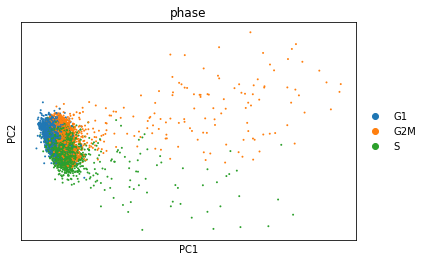

In [28]:
ad_combi_cc_genes = ad_combi[:, cell_cycle_genes_combi]
sc.tl.pca(ad_combi_cc_genes)
sc.pl.pca_scatter(ad_combi_cc_genes, color='phase')

The combined effect is reminiscent of the CTR in the seperate analysis, which is no doubt where most of the variation comes from. Let's regress these out.

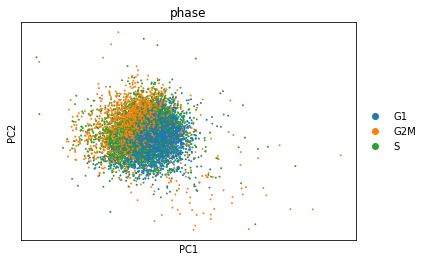

In [30]:
sc.pp.regress_out(ad_combi, ['S_score', 'G2M_score'])
sc.pp.scale(ad_combi)

ad_combi_cc_genes = ad_combi[:, cell_cycle_genes_combi]
sc.tl.pca(ad_combi_cc_genes)
sc.pl.pca_scatter(ad_combi_cc_genes, color='phase')

Regressed. 

# PCA inspection

In [31]:
sc.tl.pca(ad_combi, svd_solver='arpack')

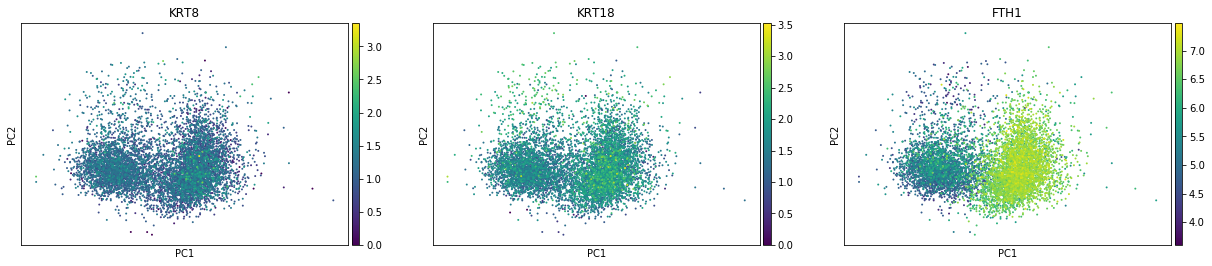

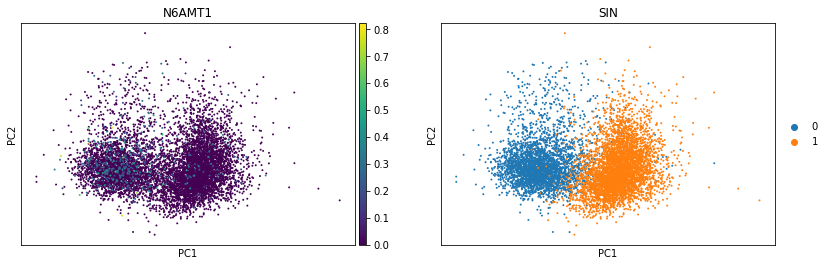

In [34]:
sc.pl.pca(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])

sc.pl.pca(ad_combi, color=['N6AMT1','SIN'])

Seperate clustering indeed observed.